# Comparing different Grassmannian metrics

This document explores a variety of distance metrics $d_*(o_1, o_2)$ for the Grassmanian $\mathcal{G}(k, N)$, and is motivated by the following questions:
* Which metric is more suitable for a specific goal?
* Given an obtained value for $d_*(o_1, o_2)$, is that value high or low?
* How good is an approximation to an existing metric?


### The metrics explored are the following:

* **Geodesic distance** ($d_g$): This is the arc-length of the geodesic path between $o_1$ and $o_2$ in  $\mathcal{G}(k, N)$.
* **Hausdorff distance** ($d_{c2}$ and $d_{cF}$): Also known as the chordal norm. This is the smallest distance between the 2 spaces spanned by $o_1$ and $o_2$, either in $\ell_2$ or $\ell_F$ norm.
* **Projection norm** ($d_{p2}$ and $d_{pF}$): Defined as $\lVert (o_1 o_1^T) - (o_2 o_2^T) \rVert_*$, where $*$ is either the $\ell_2$ or the $\ell_F$ norm.
* **Fubini-Study** ($d_a$): Also known as the *acute angle* between $o_1$ and $o_2$.
* **Overlap** ($overlap$): Defined as $\frac{1}{k} \lVert o_1^T o_2 \rVert_F^2$, this quantity is directly related to $d_{pF}$ as follows: $overlap = 1 - \frac{1}{k} d_{pF}$.
* **Intersection-over-Union** ($IoU$): Defined on orthogonal matrices $o_i$ with binary entries, yields the number of rows where *both* matrices have a 1, divided by the number of rows where *either* have a 1. When both matrices have the same $(N, k)$, this quantity is directly related to $overlap$ as follows: $IoU = \frac{overlap}{2 - overlap}$.

See section 4.3 of [The Geometry of Algorithms with Orthogonality Constraints (Edelman, Arias and Smith, 1998)](https://arxiv.org/abs/physics/9806030) and our work for more details.


### The document conducts the following steps:

1. Draw uniformly random orthogonal matrices and binary masks.
2. Compute a variety of distance metrics on them, to obtain baseline distributions.
3. Normalize distance metrics and flip them, to go from 0 (largest possible distance) to 1 (lowest possible distance i.e. $o_1 = o_2$). This means we inspect the *similarity* as the complementary quantity of *distance*.
4. We compare the results for different cases and values of $k$ and $N$.

## 1. DEPENDENCIES

In [1]:
import sys

# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install tueplots
# !conda install --yes --prefix {sys.prefix} --solver=classic ipywidgets

In [2]:
from collections import defaultdict
import math
from pprint import pprint

#
import numpy as np
from tueplots import bundles, figsizes
import matplotlib.pyplot as plt
import seaborn as sns
#
# import ipywidgets as widgets
# from ipywidgets import HBox, VBox
# from IPython.display import display
#
plt.rcParams.update(bundles.icml2022())

%matplotlib inline

In [3]:
# Seaborn setup
sns.set_theme(style="white")
colors = sns.color_palette()

## 2. RANDOM MATRICES

Functionality to uniformly sample orthogonal matrices of shape $(N, k)$, either binary or real-valued.

In [3]:
def assert_range(
    val, vmin, vmax, rtol=1e-5, atol=1e-8, msg="Value {} not in range {}!"
):
    """ """
    in_range = vmin <= val <= vmax
    # numeric tolerance around borders:
    if not in_range:
        if math.isclose(val, vmin, rel_tol=rtol, abs_tol=atol):
            in_range = True
        if math.isclose(val, vmax, rel_tol=rtol, abs_tol=atol):
            in_range = True
    assert in_range, msg.format(val, (vmin, vmax))


def random_orth(h, w):
    """
    Sample a random, thin, orthogonal matrix uniformly from Haar measure by
    sampling iid Gaussian noise followed by Gram-Schmidt orthogonalization.
    References:
    * The subgroup algorithm for generating uniform random variables
      Diaconis and Shahshahani, 1987 (section 3, method A)
    * Random orthogonal matrices and the Cayley transform
      Jauch, Hoff and Dunson, 2018 (section 6)

    :returns: Random matrix ``m`` of shape ``(h, w)`` such that ``m.T@m`` is a
      k-dimensional identity, and ``m`` is sampled uniformly.
    """
    result = np.random.randn(h, w)
    result, _ = np.linalg.qr(result)
    return result


def random_idxs(n, max_excl):
    """
    Samples ``n`` integers uniformly from 0 (included) to ``max_excl``
    (excluded), without replacement.
    """
    result = np.random.choice(max_excl, n, replace=False)
    return result


def idxs_to_mask(h, idxs):
    """
    Given a set of ``w`` indices from ``0`` to ``h - 1``, this function embeds
    them into a binary matrix of shape ``(h, w)`` containing all zeros except
    for a single 1 per column, at the corresponding ``idxs``. Returns the
    embedded matrix.
    """
    w = len(idxs)
    assert h >= w, "More idxs than h not allowed!"
    assert w == len(set(idxs)), "Repeated indices not allowed!"
    #
    result = np.zeros((h, w))
    for i, idx in enumerate(idxs):
        result[idx, i] = 1
    return result


def random_mask(h, w):
    """
    :returns: Random matrix ``m`` of shape ``(h, w)`` with binary entries,
      such that ``m.T@m`` is a k-dimensional identity, and all combinations
      have equal probability. Also returns the corresponding ``w`` nonzero
      indices.
    """
    idxs = random_idxs(w, h)
    mask = idxs_to_mask(h, idxs)
    return mask, idxs

## 3. GRASSMANNIAN METRICS

Implementation of the different metrics and related functionality as a static class.

In [4]:
class GrassMetrics:
    """
    Static class implementing different metrics on orthogonal matrices with
    shape ``(N, k)`` and ``k <= N``. References:

    The Geometry of Algorithms with Orthogonality Constraints (Edelman, Arias
    and Smith, 1998).

    Riemannian geometry of Grassmann manifolds with a view on algorithmic
    computation (Absil, Mahony and Sepulchre, 2003).
    """

    @staticmethod
    def ranges(k):
        """
        Diferent metrics on the ``(N, k)`` compact Stiefel manifold have
        predefined ranges that depend on ``k`` only. Given ``k``, this method
        returns a dictionary with the ranges for the different metrics in the
        form: ``metric_name: (min, max)``.
        """
        pi_half = np.pi * 0.5
        sqrt_2 = 2**0.5
        sqrt_k = k**0.5
        result = {
            "arc": (0, pi_half * sqrt_k),
            "c2": (0, sqrt_2),
            "cF": (0, sqrt_2 * sqrt_k),
            "p2": (0, 1),
            "pF": (0, sqrt_k),
            "p2m": (0, 1),
            "pFm": (0, sqrt_k),
            "fs": (0, pi_half),
            "fsm": (0, pi_half),
            "ov": (0, 1),
            "ovm": (0, 1),
            "iou": (0, 1),
        }
        return result

    @staticmethod
    def principal_angles(o1, o2, degrees=False):
        """
        Given 2 matrices of shape ``(N, k)``, both expected to be orthonormal
        and ``N>=k``, returns the k principal angles between them. (either in
        radians or degrees). The cosines of the principal angles are the
        eigenvalues of ``o1.T @ o2`` (see class docstring for references).


        """
        assert o1.shape == o2.shape, "Matrices must have same shape!"
        assert o1.shape[0] >= o1.shape[1], "Matrices must be thin!"
        _, cos_angles, _ = np.linalg.svd(o1.T @ o2)
        for cos in cos_angles:
            assert_range(cos, 0, 1, msg="Cosine {} should be in range {}!")
        angles = np.arccos(cos_angles.clip(0, 1))
        if degrees:
            angles = np.rad2deg(angles)
        return angles

    @staticmethod
    def arc_length(principal_angles):
        """
        The geodesic distance between 2 orthonormal matrices in a Grassmannian,
        computed from their principal angles (see class docstring).
        """
        dist = np.linalg.norm(principal_angles)
        return dist

    @staticmethod
    def dist_c2(principal_angles):
        """
        L2-chordal norm: ``inf_norm(2 * sin(angles / 2))``.
        """
        dist = max(abs(2 * np.sin(principal_angles / 2)))
        return dist

    @staticmethod
    def dist_cF(principal_angles):
        """
        Frobenius-chordal norm: ``l2_norm(2 * sin(angles / 2))``.
        """
        dist = np.linalg.norm(2 * np.sin(principal_angles / 2))
        return dist

    @staticmethod
    def dist_p2(principal_angles):
        """
        L2-projection norm: ``inf_norm(sin(angles))``.
        """
        dist = max(abs(np.sin(principal_angles)))
        return dist

    @staticmethod
    def dist_p2_mat(o1, o2):
        """
        Matrix-form computation of ``dist_p2``.
        """
        p1 = o1 @ o1.T
        p2 = o2 @ o2.T
        dist = max(abs(np.linalg.eigvalsh(p1 - p2)))
        return dist

    @staticmethod
    def dist_pF(principal_angles):
        """
        Frobenius-projection norm: ``l2_norm(sin(angles))``.
        """
        dist = np.linalg.norm(np.sin(principal_angles))
        return dist

    @staticmethod
    def dist_pF_mat(o1, o2):
        """
        Matrix-form computation of ``dist_pF``.
        """
        p1 = o1 @ o1.T
        p2 = o2 @ o2.T
        dist = np.linalg.norm(p2 - p1) / np.sqrt(2)
        return dist

    @staticmethod
    def fubini_study(principal_angles):
        """
        Fubini-Study distance: ``arccos(prod(cos(angles)))``.
        """
        dist = np.arccos(np.prod(np.cos(principal_angles)))
        return dist

    @staticmethod
    def fubini_study_mat(o1, o2):
        """
        Matrix-form computation of ``fubini_study``.
        """
        absdet = abs(np.linalg.det(o1.T @ o2))
        assert_range(absdet, 0, 1, msg="abs(determinant) {} should be in range {}!")
        dist = np.arccos(absdet.clip(0, 1))
        return dist

    @staticmethod
    def overlap(principal_angles, flip=False):
        """
        Overlap = ``1/k * l2_norm(cos(angles))**2``
        :param flip: If true, ``(1 - overlap)`` is returned instead.
        """
        k = len(principal_angles)
        ov = (1.0 / k) * sum(np.cos(principal_angles) ** 2)
        if flip:
            ov = 1 - ov
        return ov

    @staticmethod
    def overlap_mat(o1, o2, flip=False):
        """
        Matrix-form computation of overlap
        :param flip: If true, ``(1 - overlap)`` is returned instead.
        """
        _, k = o1.shape
        ov = (1.0 / k) * ((o1.T @ o2) ** 2).sum()
        if flip:
            ov = 1 - ov
        return ov

    @staticmethod
    def iou(m1, m2):
        """
        Given 2 binary orthogonal matrices (i.e. each column contains a single
        1 and each row at most one 1), this method computes the intersection-
        over-union between them, defined as the number of rows where both have
        a 1, divided by the number of rows where either has a 1.
        When both matrices have the same shape, this metric is related to
        overlap: ``iou = overlap / (2 - overlap)``.
        """
        mask1 = m1.sum(axis=1)
        mask2 = m2.sum(axis=1)
        assert (mask1 >= 0).all(), "Negative mask values?"
        assert (mask1 <= 1).all(), "Repeated mask values?"
        assert (mask2 >= 0).all(), "Negative mask values?"
        assert (mask2 <= 1).all(), "Repeated mask values?"
        #
        intersection = (mask1 * mask2).sum()
        union = np.maximum(mask1, mask2).sum()
        iou = intersection / union
        return iou

## 4. GATHER STATISTICS

We seek to inspect how do the different metric distributions behave for random matrices and masks, as a function of $N$ and $k$. For that, we gather the following 6 dictionaries, mapping each `(N, k)` key to its corresponding metric statistics:

* `orth_by_N, mask_by_N, mixed_by_N`
* `orth_by_sp, mask_by_sp, mixed_by_sp`

The `by_N` variables contain a lot of `N` computations and a few sparsities, and intend to show how do the metrics behave for a fixed sparsity, as `N` varies. The `by_sp` variables, conversely, contain a lot of `k` computations and a few `N`s, intending to show how the metrics behave for a fixed dimensionality, as sparsity varies.

Note that generating the data can take a while. If `RECOMPUTE_DATA` is false, data will be fetched from cache. Otherwise, it will be recomputed with the given parameters and stored into the cached variables:

In [5]:
def random_pair_metrics(shape=(100, 10), mask1=False, mask2=False):
    """
    Draws a random pair of ``o1, o2`` orthogonal thin matrices and computes all
    relevant metrics. If ``mask1``, then ``o1`` is a binary matrix (similarly
    with ``mask2``). If both are masks, IoU is also computed.
    :returns: A dictionary containing all metrics between the random pair.
    """
    result = {}

    o1 = random_mask(*shape)[0] if mask1 else random_orth(*shape)
    o2 = random_mask(*shape)[0] if mask2 else random_orth(*shape)
    both_masks = mask1 and mask2
    #
    angles = GrassMetrics.principal_angles(o1, o2)
    #
    arc = GrassMetrics.arc_length(angles)
    c2, cF = GrassMetrics.dist_c2(angles), GrassMetrics.dist_cF(angles)
    p2, pF = GrassMetrics.dist_p2(angles), GrassMetrics.dist_pF(angles)
    p2m = GrassMetrics.dist_p2_mat(o1, o2)
    pFm = GrassMetrics.dist_pF_mat(o1, o2)
    fs = GrassMetrics.fubini_study(angles)
    fsm = GrassMetrics.fubini_study_mat(o1, o2)
    ov = GrassMetrics.overlap(angles, flip=False)
    ovm = GrassMetrics.overlap_mat(o1, o2, flip=False)
    if both_masks:
        iou = GrassMetrics.iou(o1, o2)
    #
    # result["angles"] = angles)
    result["arc"] = arc
    result["c2"] = c2
    result["cF"] = cF
    result["p2"] = p2
    result["pF"] = pF
    result["p2m"] = p2m
    result["pFm"] = pFm
    result["fs"] = fs
    result["fsm"] = fsm
    result["ov"] = ov
    result["ovm"] = ovm
    if both_masks:
        result["iou"] = iou
    #
    return result


def get_unif_metrics(
    shape=(100, 10),
    num_samples=100,
    mask1=False,
    mask2=False,
    normalize_ranges=False,
    verbose=True,
    consistency_atol=1e-5,
):
    """
    Calls ``random_pair_metrics`` for ``num_samples`` times, extracting matrix
    pairs of given ``shape``. Then gathers the ``GrassMetrics`` between each
    pair, and checks that resulting values are consistent in their range and
    relation to each other. Finally, returns the values.
    See the ``random_pair_metrics`` docstring for more info.

    :param normalize_ranges: If true, returned metrics will be between
      0 and 1. For overlap and IoU, higher means more similarity. For the
      the remaining distances, lower means more similarity.
    :returns: A dictionary with the gathered metrics for the samples.
    """
    N, k = shape
    all_metrics = defaultdict(list)
    both_masks = mask1 and mask2
    #
    for t in range(num_samples):
        metrics = random_pair_metrics(shape, mask1, mask2)
        arc = metrics["arc"]
        c2, cF = metrics["c2"], metrics["cF"]
        p2, p2m = metrics["p2"], metrics["p2m"]
        pF, pFm = metrics["pF"], metrics["pFm"]
        fs, fsm = metrics["fs"], metrics["fsm"]
        ov, ovm = metrics["ov"], metrics["ovm"]
        if both_masks:
            iou = metrics["iou"]

        # check equivalences between computed metrics
        assert math.isclose(
            p2, p2m, abs_tol=consistency_atol
        ), f"Inconsistent p2 metrics!"
        assert math.isclose(
            pF, pFm, abs_tol=consistency_atol
        ), "Inconsistent pF metrics!"
        assert math.isclose(
            fs, fsm, abs_tol=consistency_atol
        ), f"Inconsistent F-S metrics! {fs, fsm}"
        assert math.isclose(
            ov, ovm, abs_tol=consistency_atol
        ), "Inconsistent overlap metrics!"
        assert math.isclose(
            1 - ov, (pF**2 * (1.0 / k)), abs_tol=consistency_atol
        ), "Inconsistent overlap <--> pF metrics!"
        if both_masks:
            assert math.isclose(
                ov, 2 * iou / (1 + iou), abs_tol=consistency_atol
            ), "Inconsistent overlap <--> iou metrics!"
            assert math.isclose(
                iou, ov / (2 - ov), abs_tol=consistency_atol
            ), "Inconsistent iou <--> overlap metrics!"

        # check that metrics lie in expected ranges
        ranges = GrassMetrics.ranges(k)
        arc_0, arc_1 = ranges["arc"]
        c2_0, c2_1 = ranges["c2"]
        cF_0, cF_1 = ranges["cF"]
        p2_0, p2_1 = ranges["p2"]
        pF_0, pF_1 = ranges["pF"]
        fs_0, fs_1 = ranges["fs"]
        ov_0, ov_1 = ranges["ov"]
        #
        assert_range(arc, arc_0, arc_1, msg="Arc length {} not in {}!")
        assert_range(c2, c2_0, c2_1, msg="c2 {} not in {}!")
        assert_range(cF, cF_0, cF_1, msg="cF {} not in {}!")
        assert_range(p2, p2_0, p2_1, msg="p2 {} not in {}!")
        assert_range(pF, pF_0, pF_1, msg="pF {} not in {}!")
        assert_range(fs, fs_0, fs_1, msg="fs {} not in {}!")
        assert_range(ov, ov_0, ov_1, msg="ov {} not in {}!")
        if both_masks:
            iou_0, iou_1 = ranges["iou"]
            assert_range(iou, iou_0, iou_1, msg="IoU {} not in {}!")

        # aggregate results
        for metric, val in metrics.items():
            if normalize_ranges:
                lo, hi = ranges[metric]
                val = (val - lo) / (hi - lo)
            all_metrics[metric].append(val)
        #
        if verbose:
            mat1 = "mask" if mask1 else "orth"
            mat2 = "mask" if mask2 else "orth"
            print(f"Random {mat1}-{mat2} test [iter {t}]: OK")
    #
    return all_metrics


def get_metric_stats(sample_dicts, quantiles=()):
    """
    Aggregates the result of ``get_unif_metrics`` to extract the median
    (and optionally quantile ranges) from the gathered samples.
    :param sample_dicts: Dictionary in the form ``(N, k): sample_dict``,
      where each sample_dict contains ``dist_name: samples`` pairs.
    :param quantile: Surfaces of the data distribution to be plotted, given
      as a collection of quantile pairs in the form ``((low, high), ...)``,
      e.g. ``[(0.05, 0.95), (0.25, 0.75)]``.
    :returns: A dictionary with same keys as inputs, mapping to dicts
      in the form ``metric: (median, quantiles)``.
    """
    all_stats = {}
    for key, sample_dict in sample_dicts.items():
        stats = {}
        for metric, samples in sample_dict.items():
            median = np.median(samples)
            quants = [
                (np.quantile(samples, q0), np.quantile(samples, q1))
                for q0, q1 in quantiles
            ]
            stats[metric] = (median, quants)
        all_stats[key] = stats
    #
    return all_stats

In [4]:
RECOMPUTE_DATA = False
NUM_SAMPLES = 50  # Number of random pairs to compute distance on, for each (N, k) case.
QUANTILES = (
    (0.05, 0.95),
    (0.25, 0.75),
)  # Besides the median, which quantile ranges to compute

# Many Ns, few sparsities
DIMS_BY_N = [16, 32, 64, 128, 256, 512, 1024, 2048]
# DIMS_BY_N = np.unique(np.exp(np.linspace(0, 6, 5)).round()) + 10
SPARSITIES_BY_N = [0.4, 0.2, 0.05, 0.01, 0.005]

# Many sparsities, few Ns
DIMS_BY_SP = [128, 256, 512, 1024]
# Shrinking distributions saturate near 1, and proportional metrics behave differently near 0.
# Hence, higher SpSp resolution near the ends
SPARSITIES_BY_SP = [1, 0.99, 0.95, 0.9, 0.6, 0.3, 0.1, 0.05, 0.01, 0.005]

if RECOMPUTE_DATA:
    # compute stats by dimension N
    orth_N, mask_N, mixed_N = {}, {}, {}
    for dim in DIMS_BY_N:
        for sparsity in SPARSITIES_BY_N:
            dim = round(dim)
            k = max(round(sparsity * dim), 1)
            print("Computing", (dim, k))
            orth_N[(dim, k, sparsity)] = get_unif_metrics(
                (dim, k), NUM_SAMPLES, mask1=False, mask2=False, normalize_ranges=True
            )
            mask_N[(dim, k, sparsity)] = get_unif_metrics(
                (dim, k), NUM_SAMPLES, mask1=True, mask2=True, normalize_ranges=True
            )
            mixed_N[(dim, k, sparsity)] = get_unif_metrics(
                (dim, k), NUM_SAMPLES, mask1=False, mask2=True, normalize_ranges=True
            )
    orth_by_N = get_metric_stats(orth_N, QUANTILES)
    mask_by_N = get_metric_stats(mask_N, QUANTILES)
    mixed_by_N = get_metric_stats(mixed_N, QUANTILES)
    del orth_N, mask_N, mixed_N
    # compute data by sparsity
    orth_sp, mask_sp, mixed_sp = {}, {}, {}
    for dim in DIMS_BY_SP:
        for sparsity in SPARSITIES_BY_SP:
            dim = round(dim)
            k = max(round(sparsity * dim), 1)
            print("Computing", (dim, k))
            orth_sp[(dim, k, sparsity)] = get_unif_metrics(
                (dim, k), NUM_SAMPLES, mask1=False, mask2=False, normalize_ranges=True
            )
            mask_sp[(dim, k, sparsity)] = get_unif_metrics(
                (dim, k), NUM_SAMPLES, mask1=True, mask2=True, normalize_ranges=True
            )
            mixed_sp[(dim, k, sparsity)] = get_unif_metrics(
                (dim, k), NUM_SAMPLES, mask1=False, mask2=True, normalize_ranges=True
            )
    orth_by_sp = get_metric_stats(orth_sp, QUANTILES)
    mask_by_sp = get_metric_stats(mask_sp, QUANTILES)
    mixed_by_sp = get_metric_stats(mixed_sp, QUANTILES)
    del orth_sp, mask_sp, mixed_sp

    #
    metadata = {
        "num_samples": NUM_SAMPLES,
        "quantiles": QUANTILES,
        "dims_by_N": DIMS_BY_N,
        "sparsities_by_N": SPARSITIES_BY_N,
        "dims_by_sp": DIMS_BY_SP,
        "sparsities_by_sp": SPARSITIES_BY_SP,
    }
    #
    %store orth_by_N
    %store mask_by_N
    %store mixed_by_N
    %store orth_by_sp
    %store mask_by_sp
    %store mixed_by_sp
    %store metadata
    print("Computed and stored data to cache!", metadata, sep="\n")
else:
    orth_by_N = None
    %store -r orth_by_N
    %store -r mask_by_N
    %store -r mixed_by_N
    %store -r orth_by_sp
    %store -r mask_by_sp
    %store -r mixed_by_sp
    %store -r metadata
    assert isinstance(orth_by_N, dict), "Data not retrieved? Try RECOMPUTE_DATA=True"
    print("Retrieved data from cache!")
    pprint(metadata)

Retrieved data from cache!
{'dims_by_N': [16, 32, 64, 128, 256, 512, 1024, 2048],
 'dims_by_sp': [128, 256, 512, 1024],
 'num_samples': 50,
 'quantiles': ((0.05, 0.95), (0.25, 0.75)),
 'sparsities_by_N': [0.4, 0.2, 0.05, 0.01, 0.005],
 'sparsities_by_sp': [1, 0.99, 0.95, 0.9, 0.6, 0.3, 0.1, 0.05, 0.01, 0.005]}


## 5. PLOT STATISTICS

In [10]:
class LineplotStats:
    """
    Plotter class for our synthetic data.
    """

    # distance or overlap? i.e. does increased value mean less similarity?
    IS_DISTANCE = {
        "arc": True,
        "c2": True,
        "cF": True,
        "p2": True,
        "pF": True,
        "p2m": True,
        "pFm": True,
        "fs": True,
        "fsm": True,
        "ov": False,
        "ovm": False,
        "iou": False,
    }

    COLORBLIND_COLORS = [
        "#377eb8",
        "#ff7f00",
        "#4daf4a",
        "#f781bf",
        "#a65628",
        "#984ea3",
        "#999999",
        "#e41a1c",
        "#dede00",
    ]

    @classmethod
    def _plotrow_by_N(
        cls,
        ax_row,
        metrics,
        sparsities,
        dicts,
        boundary_color=None,
        linewidth=0.5,
        quant_alpha=0.25,
        larger_is_similar=True,
    ):
        """
        Helper method.
        """
        for col_i, metric in enumerate(metrics):
            ax = ax_row[col_i]
            ax.set_ylim(*ylim)
            #
            for sp_i, sp in enumerate(sparsities):
                keys = [k for k in dicts if k[2] == sp]
                xvals = [height for height, _, _ in keys]
                if boundary_color is not None:
                    # plot hlines at 0 and 1 (limits)
                    ax.axhline(y=0, color=boundary_color, linewidth=linewidth)
                    ax.axhline(y=1, color=boundary_color, linewidth=linewidth)
                # extract medians and quantile bounds for this sparsity level
                # and metric
                medians, quants = zip(*(dicts[key][metric] for key in keys))
                quants = list(zip(*quants))
                # plot medians
                if (larger_is_similar and cls.IS_DISTANCE[metric]) or (
                    (not larger_is_similar) and (not cls.IS_DISTANCE[metric])
                ):
                    medians = 1 - np.array(medians)
                ax.plot(
                    xvals,
                    medians,
                    color=cls.COLORBLIND_COLORS[sp_i],
                    label=f"sparsity: {sp}",
                    linewidth=linewidth,
                )
                # plot quants
                for llhh in quants:
                    ll, hh = zip(*llhh)
                    if (larger_is_similar and cls.IS_DISTANCE[metric]) or (
                        (not larger_is_similar) and (not cls.IS_DISTANCE[metric])
                    ):
                        ll = 1 - np.array(ll)
                        hh = 1 - np.array(hh)
                    ax.fill_between(
                        xvals,
                        ll,
                        hh,
                        facecolor=cls.COLORBLIND_COLORS[sp_i],
                        alpha=quant_alpha,
                    )
            ax.legend(loc="upper right")

    @classmethod
    def _plotrow_by_sp(
        cls,
        ax_row,
        metrics,
        heights,
        dicts,
        boundary_color=None,
        linewidth=0.5,
        quant_alpha=0.25,
        larger_is_similar=True,
    ):
        """
        Helper method.
        """
        for col_i, metric in enumerate(metrics):
            ax = ax_row[col_i]
            ax.set_ylim(*ylim)
            #
            for N_i, N in enumerate(heights):
                keys = [k for k in dicts if k[0] == N]
                xvals = [width for _, width, _ in keys]
                if boundary_color is not None:
                    # plot hlines at 0 and 1 (limits)
                    ax.axhline(y=0, color=boundary_color, linewidth=linewidth)
                    ax.axhline(y=1, color=boundary_color, linewidth=linewidth)
                # extract medians and quantile bounds for this dimension level
                # and metric
                medians, quants = zip(*(dicts[key][metric] for key in keys))
                quants = list(zip(*quants))
                # plot medians
                if (larger_is_similar and cls.IS_DISTANCE[metric]) or (
                    (not larger_is_similar) and (not cls.IS_DISTANCE[metric])
                ):
                    medians = 1 - np.array(medians)
                ax.plot(
                    xvals,
                    medians,
                    color=cls.COLORBLIND_COLORS[N_i],
                    label=f"N={N}",
                    linewidth=linewidth,
                )
                # plot quants
                for llhh in quants:
                    ll, hh = zip(*llhh)
                    if (larger_is_similar and cls.IS_DISTANCE[metric]) or (
                        (not larger_is_similar) and (not cls.IS_DISTANCE[metric])
                    ):
                        ll = 1 - np.array(ll)
                        hh = 1 - np.array(hh)
                    ax.fill_between(
                        xvals,
                        ll,
                        hh,
                        facecolor=cls.COLORBLIND_COLORS[N_i],
                        alpha=quant_alpha,
                    )
            ax.legend(loc="upper right")

    @classmethod
    def plot_all(
        cls,
        orth_dicts,
        mask_dicts,
        mixed_dicts,
        figsize=(20, 15),
        ylim=(0, 1),
        ignore_keys={"p2m", "pFm", "fsm", "ovm", "iou"},
        boundary_color="red",
        linewidth=0.5,
        quant_alpha=0.25,
        larger_is_similar=True,
        by_sp_instead=False,
    ):
        """
        :param orth_dicts: Dictionary in the form ``(N, k, sparsity): v``,
          where each ``v`` is a dictionary in the form
          ``metric: (med, ((lo1, hi1), ...))`` containing median and quantiles
          for the orth-vs-orth experiment.
        :param mask_dicts: like ``orth_dicts``, but mask-vs-mask experiment.
        :param mixed_dicts: like ``orth_dicts``, but orth-vs-mask experiment.
        :param bool larger_is_similar: If true, larger values mean more
          similarity.
        """
        metrics = sorted(
            k for k in next(iter(orth_dicts.values())) if k not in ignore_keys
        )
        heights, widths, sparsities = zip(*orth_dicts.keys())
        heights, widths, sparsities = (
            np.unique(heights),
            np.unique(widths),
            sorted(np.unique(sparsities)),
        )
        #
        fig, axes = plt.subplots(nrows=3, ncols=len(metrics), figsize=figsize)
        #
        if by_sp_instead:
            method = cls._plotrow_by_sp
            x_ax = heights
        else:
            method = cls._plotrow_by_N
            x_ax = sparsities
        method(
            axes[0],
            metrics,
            x_ax,
            orth_dicts,
            boundary_color,
            linewidth,
            quant_alpha,
            larger_is_similar,
        )
        method(
            axes[1],
            metrics,
            x_ax,
            mixed_dicts,
            boundary_color,
            linewidth,
            quant_alpha,
            larger_is_similar,
        )
        method(
            axes[2],
            metrics,
            x_ax,
            mask_dicts,
            boundary_color,
            linewidth,
            quant_alpha,
            larger_is_similar,
        )
        #
        for metric, ax in zip(metrics, axes[0]):
            if (larger_is_similar and cls.IS_DISTANCE[metric]) or (
                (not larger_is_similar) and (not cls.IS_DISTANCE[metric])
            ):
                metric = "1 - " + metric
            ax.set_title(metric)
        #
        axes[0, 0].set_ylabel("Orth-vs-Orth")
        axes[1, 0].set_ylabel("Orth-vs-Mask")
        axes[2, 0].set_ylabel("Mask-vs-Mask")
        #
        for metric, ax in zip(metrics, axes[-1, :]):
            if by_sp_instead:
                ax.set_label("Sparsity (k/N) approx.")
            else:
                ax.set_label("Dimension (N)")
        #
        return fig, axes

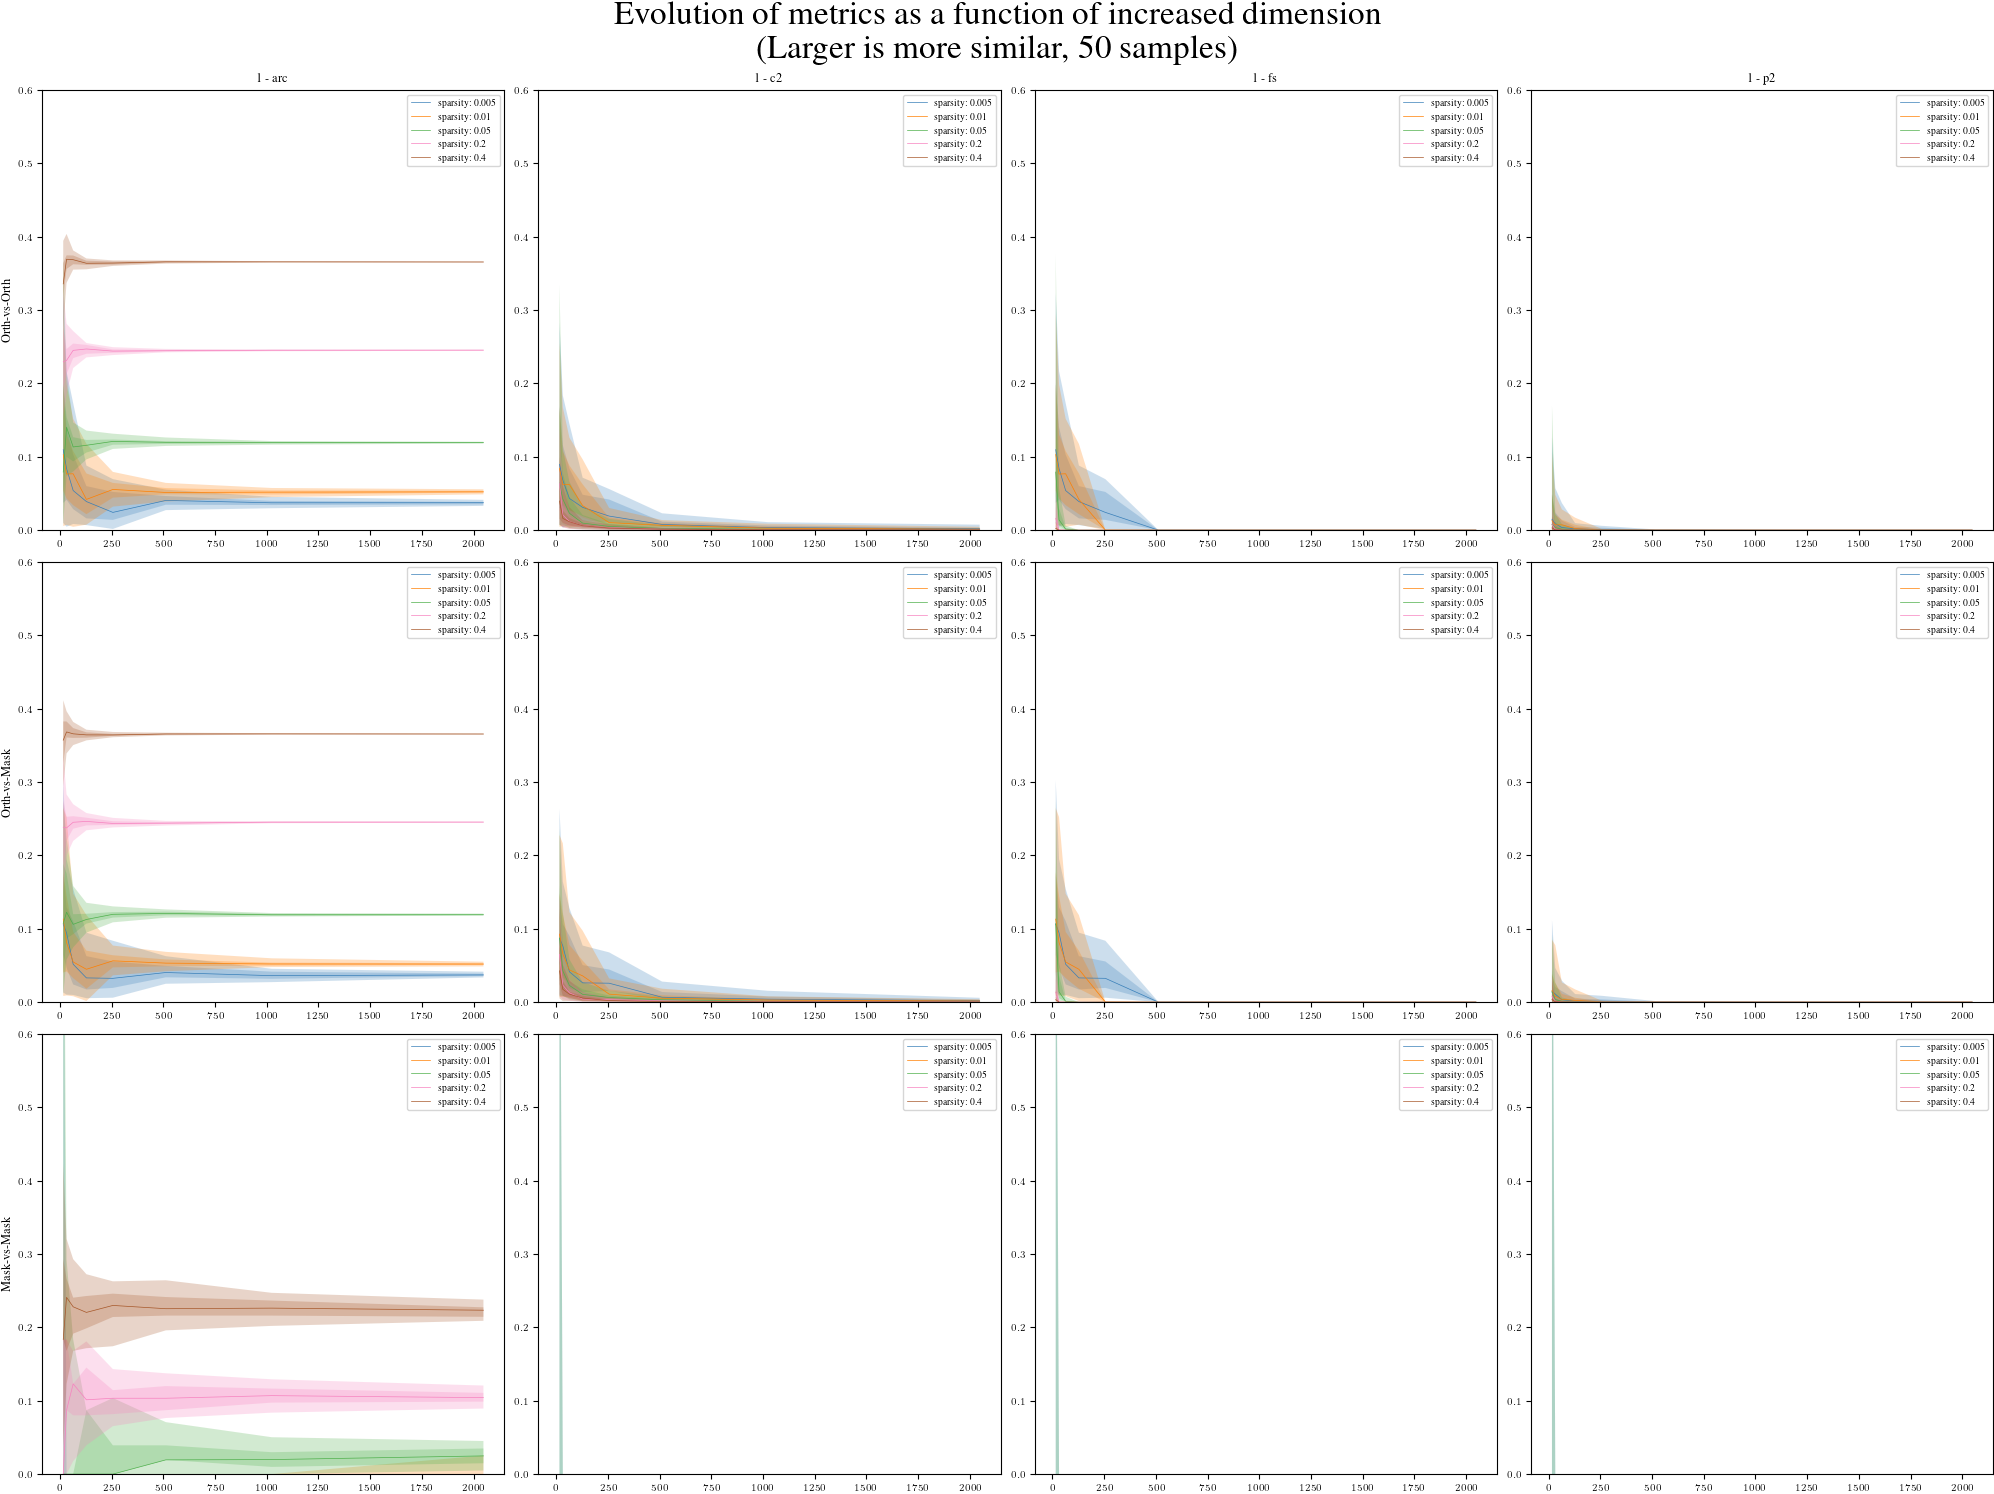

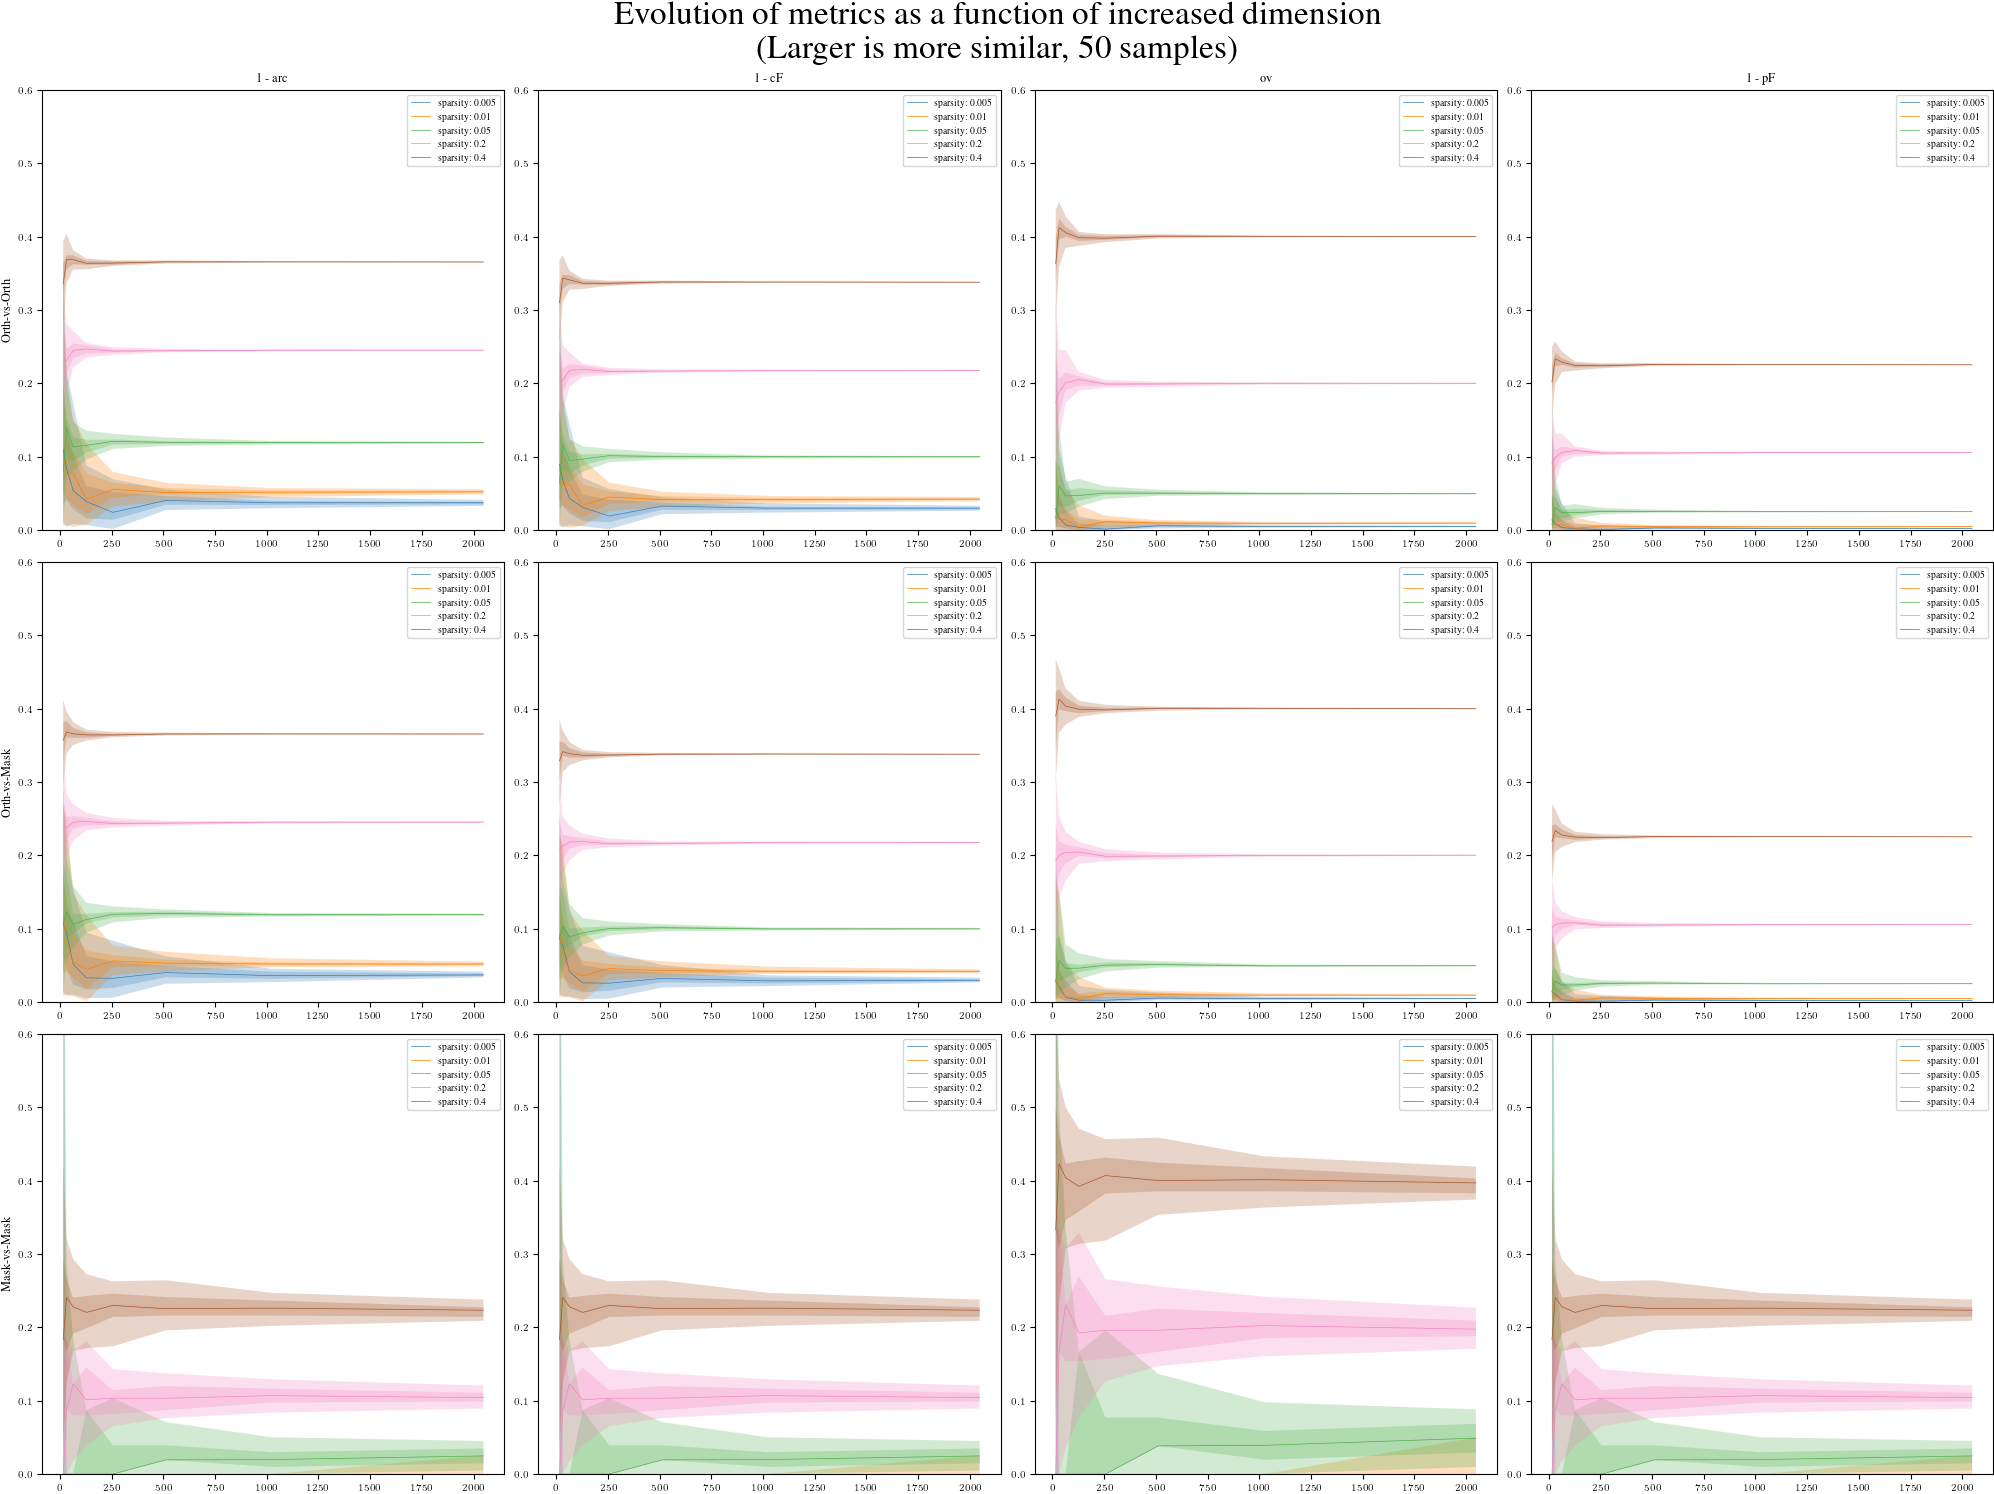

In [11]:
larger_is_similar = True
ylim = (0, 0.6)
#
fig_by_N_1, _ = LineplotStats.plot_all(
    orth_by_N,
    mask_by_N,
    mixed_by_N,
    figsize=(20, 15),
    ylim=ylim,
    ignore_keys={"p2m", "pFm", "fsm", "ovm", "cF", "pF", "ov"},
    boundary_color=None,
    linewidth=0.5,
    quant_alpha=0.25,
    larger_is_similar=larger_is_similar,
    by_sp_instead=False,
)
fig_by_N_1.suptitle(
    "Evolution of metrics as a function of increased dimension\n"
    + "(Larger is more similar, {} samples)".format(metadata["num_samples"]),
    fontsize=24,
)
#
fig_by_N_2, _ = LineplotStats.plot_all(
    orth_by_N,
    mask_by_N,
    mixed_by_N,
    figsize=(20, 15),
    ylim=ylim,
    ignore_keys={"p2m", "pFm", "fsm", "ovm", "fs", "c2", "p2"},
    boundary_color=None,
    linewidth=0.5,
    quant_alpha=0.25,
    larger_is_similar=larger_is_similar,
    by_sp_instead=False,
)
fig_by_N_2.suptitle(
    "Evolution of metrics as a function of increased dimension\n"
    + "(Larger is more similar, {} samples)".format(metadata["num_samples"]),
    fontsize=24,
)

fig_by_N_1.savefig("output_plots/shrinking.svg")
fig_by_N_2.savefig("output_plots/proportional.svg")
None

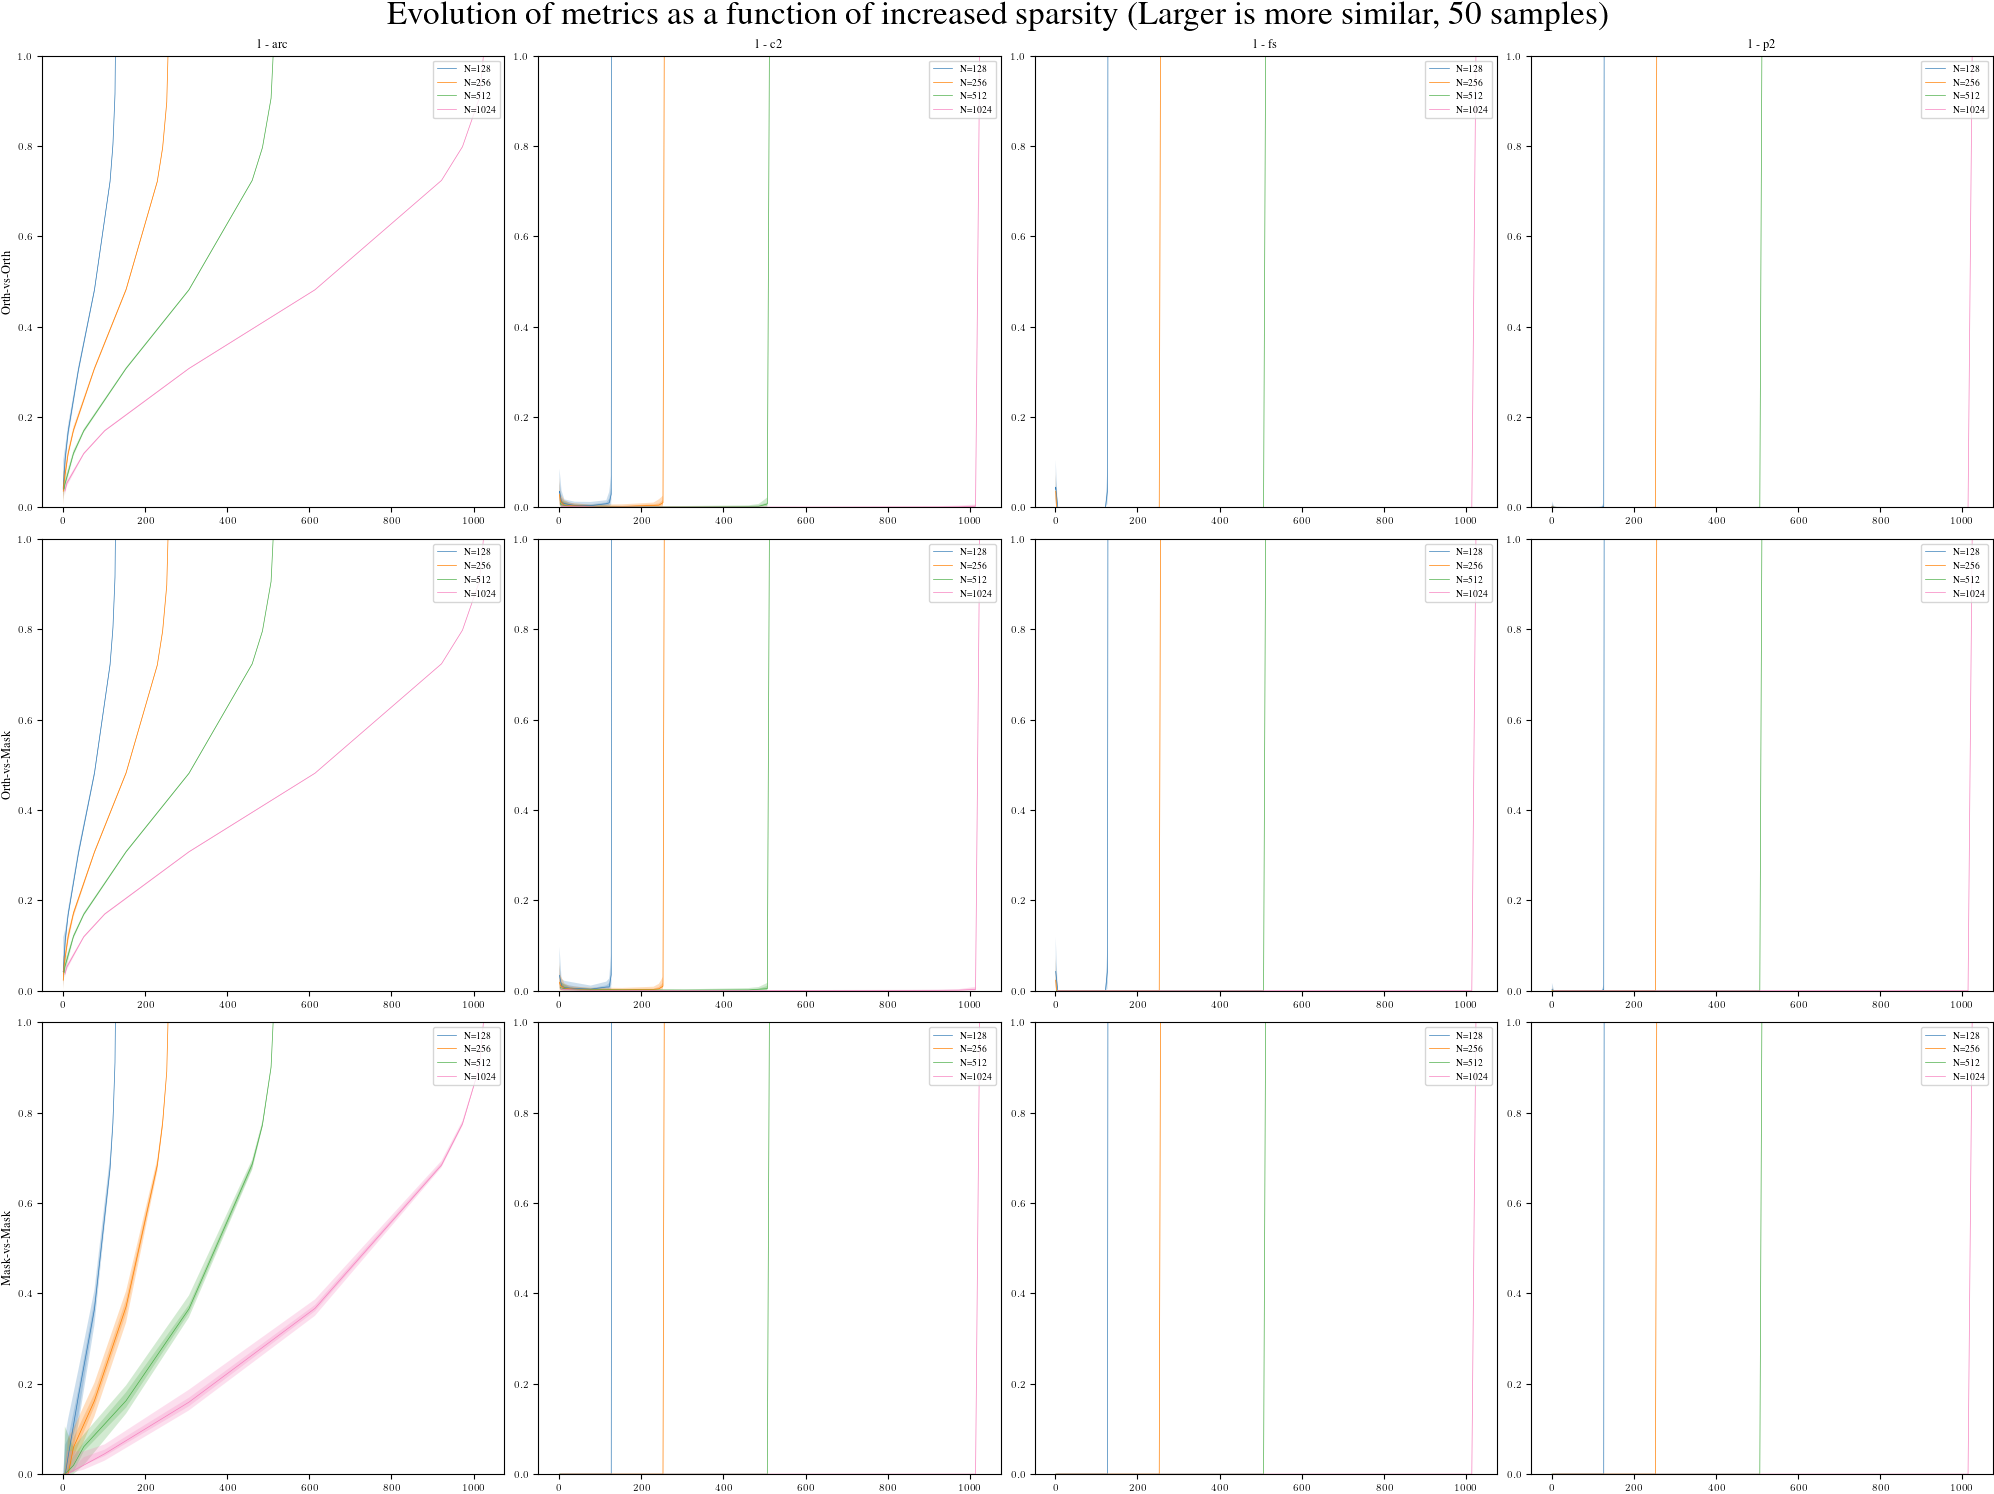

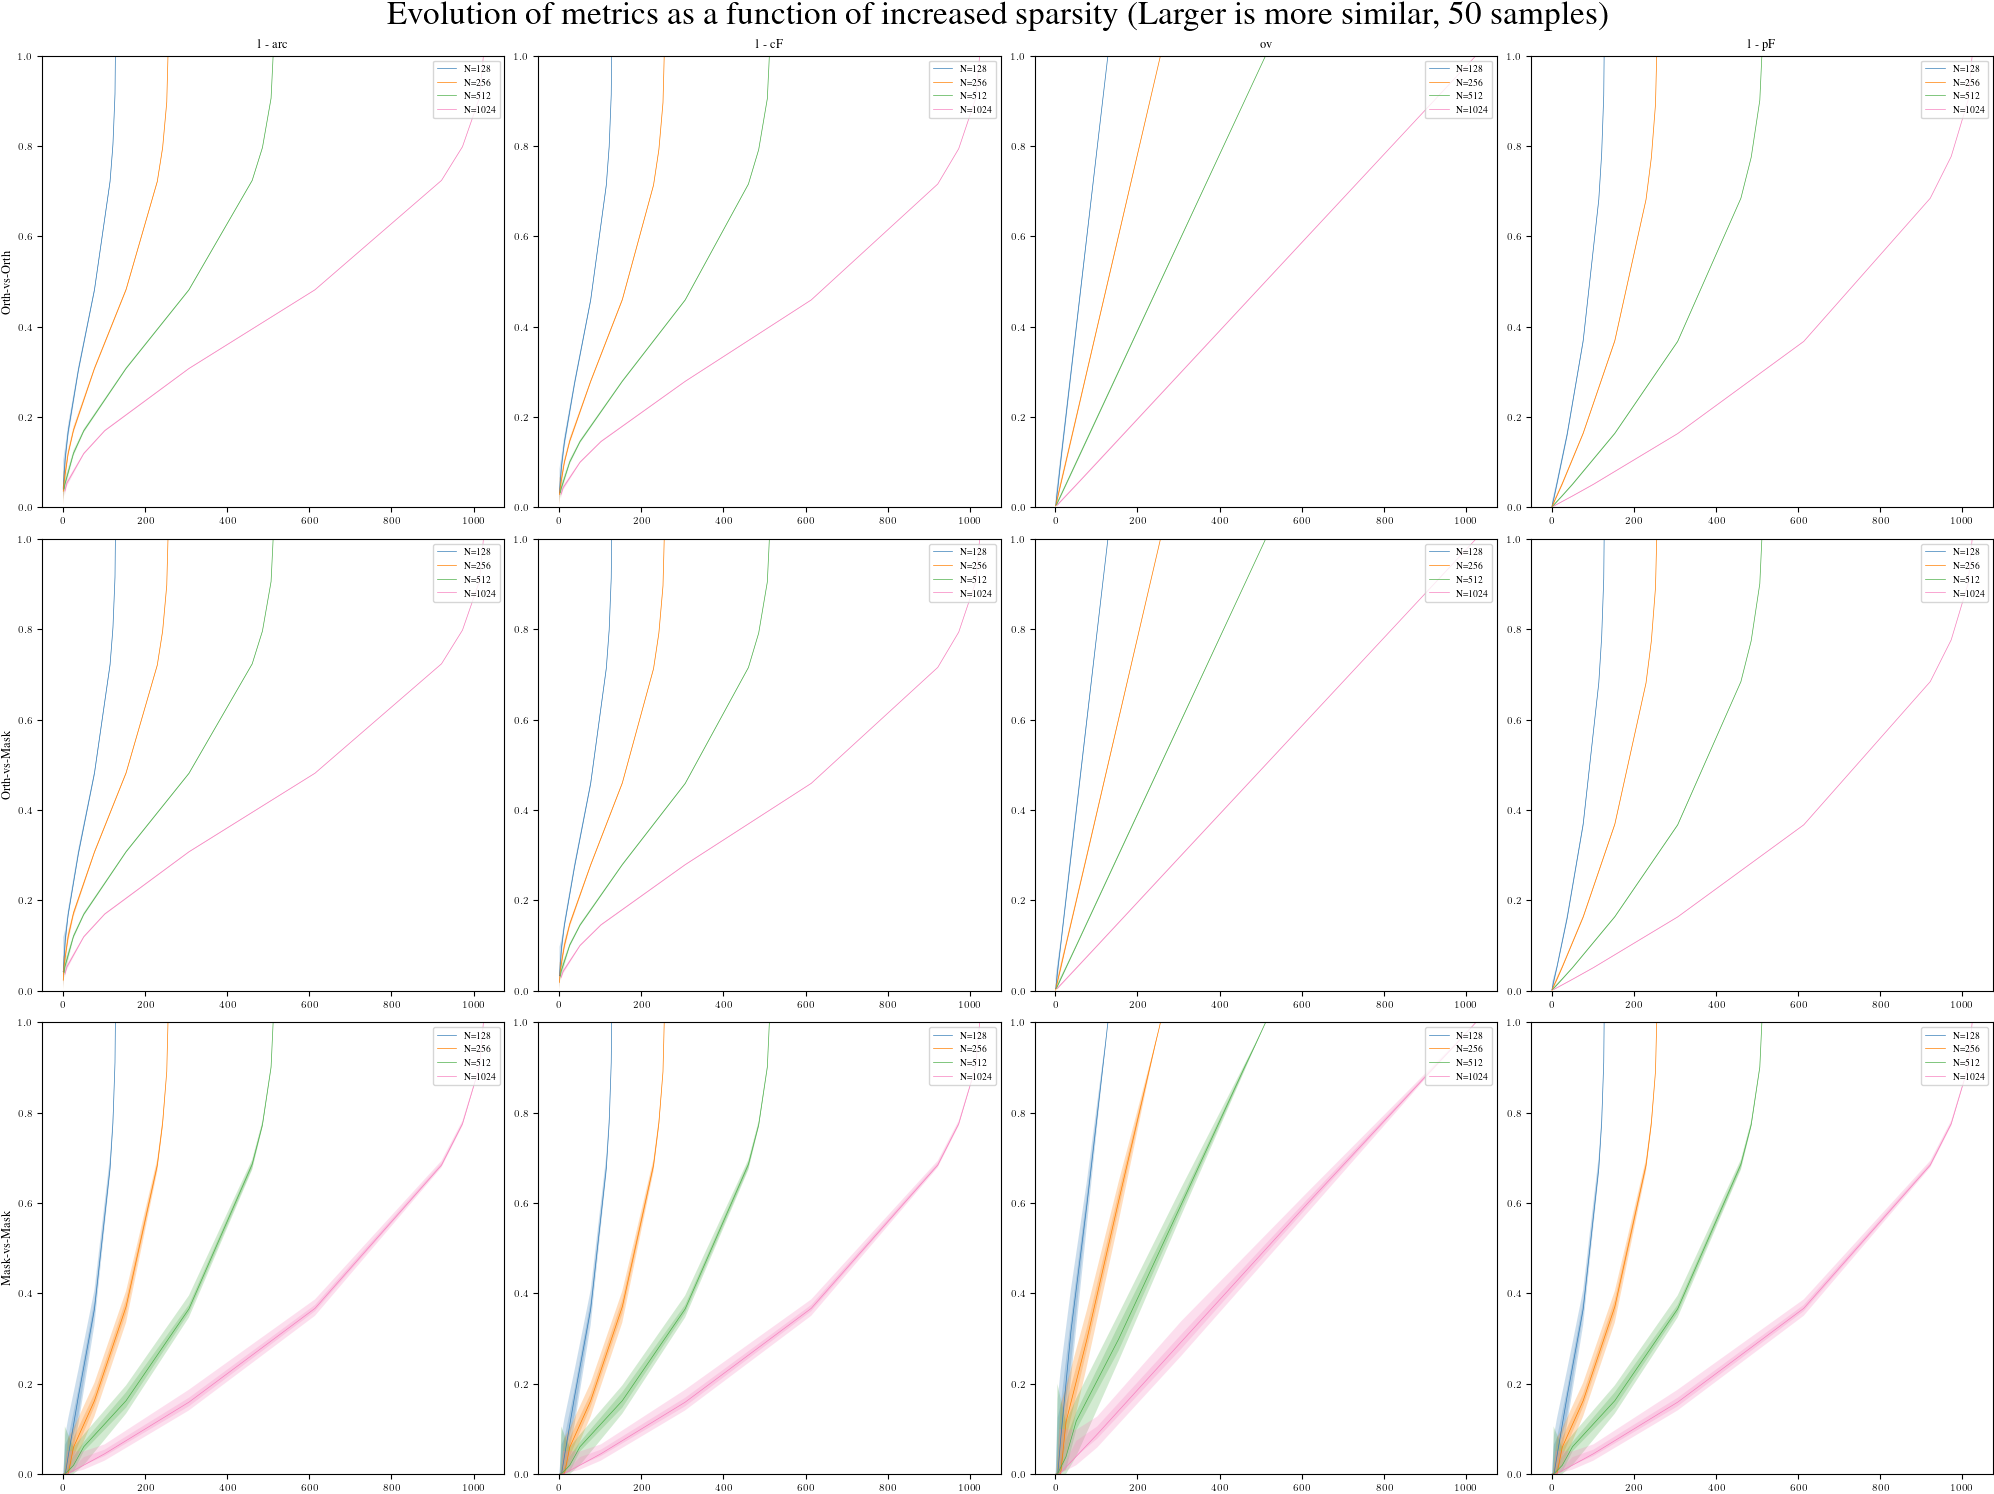

In [12]:
larger_is_similar = True
ylim = (0, 1.0)
#
fig_by_sp_1, _ = LineplotStats.plot_all(
    orth_by_sp,
    mask_by_sp,
    mixed_by_sp,
    figsize=(20, 15),
    ylim=ylim,
    ignore_keys={"p2m", "pFm", "fsm", "ovm", "cF", "pF", "ov"},
    boundary_color=None,
    linewidth=0.5,
    quant_alpha=0.25,
    larger_is_similar=larger_is_similar,
    by_sp_instead=True,
)
fig_by_sp_1.suptitle(
    "Evolution of metrics as a function of increased sparsity "
    + "(Larger is more similar, {} samples)".format(metadata["num_samples"]),
    fontsize=24,
)
#
fig_by_sp_2, _ = LineplotStats.plot_all(
    orth_by_sp,
    mask_by_sp,
    mixed_by_sp,
    figsize=(20, 15),
    ylim=ylim,
    ignore_keys={"p2m", "pFm", "fsm", "ovm", "fs", "p2", "c2"},
    boundary_color=None,
    linewidth=0.5,
    quant_alpha=0.25,
    larger_is_similar=larger_is_similar,
    by_sp_instead=True,
)
fig_by_sp_2.suptitle(
    "Evolution of metrics as a function of increased sparsity "
    + "(Larger is more similar, {} samples)".format(metadata["num_samples"]),
    fontsize=24,
)
None

## 6. PRINT FINAL BASELINES

In [5]:
%store -r orth_by_N
%store -r mask_by_N
%store -r mixed_by_N
%store -r metadata
pprint(metadata)
#
ignore_keys = {"p2m", "pFm", "fsm", "ovm", "iou"}
metrics = sorted(k for k in next(iter(mixed_by_N.values()))
                 if k not in ignore_keys)
heights, widths, sparsities = zip(*mixed_by_N.keys())
heights, widths, sparsities = (np.unique(heights), np.unique(widths),
                               sorted(np.unique(sparsities)))
#
all_medians = defaultdict(dict)
N = max(heights)
for sp in sparsities:
    for m in metrics:
        mixed_entries = {(h, k, s): v for (h, k, s), v in mixed_by_N.items()
                        if h == N and s == sp}
        assert len(mixed_entries) == 1, "Data is corrupt?"
        k = list(mixed_entries.keys())[0][1]
        median = mixed_entries[(N, k, sp)][m][0]
        all_medians[m][(N, sp)] = median

pprint(all_medians)



{'dims_by_N': [16, 32, 64, 128, 256, 512, 1024, 2048],
 'dims_by_sp': [128, 256, 512, 1024],
 'num_samples': 50,
 'quantiles': ((0.05, 0.95), (0.25, 0.75)),
 'sparsities_by_N': [0.4, 0.2, 0.05, 0.01, 0.005],
 'sparsities_by_sp': [1, 0.99, 0.95, 0.9, 0.6, 0.3, 0.1, 0.05, 0.01, 0.005]}
defaultdict(<class 'dict'>,
            {'arc': {(2048, 0.005): 0.9628948312344412,
                     (2048, 0.01): 0.9480938109578216,
                     (2048, 0.05): 0.8809053138548071,
                     (2048, 0.2): 0.7546553168097724,
                     (2048, 0.4): 0.6346388372646588},
             'c2': {(2048, 0.005): 0.9980311503768766,
                    (2048, 0.01): 0.9983943414120398,
                    (2048, 0.05): 0.9995235150637188,
                    (2048, 0.2): 0.9995448435198324,
                    (2048, 0.4): 0.9997403447481734},
             'cF': {(2048, 0.005): 0.9701721012328479,
                    (2048, 0.01): 0.9579794158467092,
                    (2048, 0.05):

## 7. PLOTS FOR PAPER

In [45]:
ACCESSIBLE_COLORS = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]


FILTER_SPARSITIES = [0.005]  # 0.01 select which by-D lines to ignore
FILTER_DIMS = []  # select which by-r lines to ignore
FIG_HEIGHT = 1.1
LINEWIDTH = 1.0
LEGEND_POS = (0.85, 0.9)


AXIS_LINEWIDTH = 0.5
plt.rcParams["axes.linewidth"] = AXIS_LINEWIDTH  # set the value globally
plt.rcParams["xtick.major.size"] = plt.rcParamsDefault["xtick.major.size"]
plt.rcParams["xtick.major.width"] = AXIS_LINEWIDTH
plt.rcParams["xtick.minor.size"] = plt.rcParamsDefault["xtick.minor.size"]
plt.rcParams["xtick.minor.width"] = AXIS_LINEWIDTH
plt.rcParams["ytick.major.size"] = plt.rcParamsDefault["xtick.major.size"]
plt.rcParams["ytick.major.width"] = AXIS_LINEWIDTH
plt.rcParams["ytick.minor.size"] = plt.rcParamsDefault["xtick.minor.size"]
plt.rcParams["ytick.minor.width"] = AXIS_LINEWIDTH


def plot_single(
    dist_dicts,
    ax,
    metric="ov",
    fn_y=lambda yyy: yyy,
    by_k=False,
    colors=ACCESSIBLE_COLORS,
    quant_alpha=0.25,
    filter_out_keys=tuple(),
    linewidth=0.5,
    bottom_plot=False,
):
    """ """
    dicts = {(D, k, r): v[metric] for (D, k, r), v in dist_dicts.items()}
    all_medians = {k: v[0] for k, v in dicts.items()}
    all_quantiles = {k: v[1] for k, v in dicts.items()}
    all_D, all_k, all_r = zip(*all_medians)
    all_D, all_k, all_r = sorted(set(all_D)), sorted(set(all_k)), sorted(set(all_r))
    #
    if by_k:
        all_D = [D for D in all_D if D not in filter_out_keys]
        # print("KEYS:", all_D)
        for i, dim in enumerate(all_D):
            DD, kk, rr, medians = zip(
                *((D, k, r, v) for (D, k, r), v in all_medians.items() if D == dim)
            )
            DD, kk, rr, quants = zip(
                *((D, k, r, v) for (D, k, r), v in all_quantiles.items() if D == dim)
            )
            unique_idxs = sorted(
                {(D, k): i for i, (D, k) in enumerate(zip(DD, kk))}.values()
            )
            ax.plot(
                [rr[i] for i in unique_idxs],
                fn_y([medians[i] for i in unique_idxs]),
                c=colors[i],
                linewidth=linewidth,
                label=rf"$D={dim}$",
                alpha=0.5,
            )
            #
            #
            for q, quant_pairs in enumerate(zip(*quants)):
                # Hotfix to only plot one shaded area
                if q == 0:
                    lo, hi = zip(*quant_pairs)
                    ax.fill_between(
                        [rr[i] for i in unique_idxs],
                        fn_y([lo[i] for i in unique_idxs]),
                        fn_y([hi[i] for i in unique_idxs]),
                        facecolor=colors[i],
                        alpha=quant_alpha,
                    )

        ax.set_xlim(0, 1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="both", length=2, pad=4)
        ax.set_yticks([0.0, 0.5, 1.0])
        if bottom_plot:
            ax.set_xlabel(r"$\rho$")
    #
    else:
        all_r = [r for r in all_r if r not in filter_out_keys]
        # print("KEYS:", all_r)
        for i, ratio in enumerate(all_r):
            DD, kk, rr, medians = zip(
                *((D, k, r, v) for (D, k, r), v in all_medians.items() if r == ratio)
            )
            DD, kk, rr, quants = zip(
                *((D, k, r, v) for (D, k, r), v in all_quantiles.items() if r == ratio)
            )
            unique_idxs = sorted(
                {(D, k): i for i, (D, k) in enumerate(zip(DD, kk))}.values()
            )
            ax.plot(
                [DD[i] for i in unique_idxs],
                fn_y([medians[i] for i in unique_idxs]),
                c=colors[i],
                linewidth=linewidth,
                label=rf"$\rho={ratio}$",
            )
            #
            #
            for q, quant_pairs in enumerate(zip(*quants)):
                # Hotfix to only plot one shaded area
                if q == 0:
                    lo, hi = zip(*quant_pairs)
                    ax.fill_between(
                        [DD[i] for i in unique_idxs],
                        fn_y([lo[i] for i in unique_idxs]),
                        fn_y([hi[i] for i in unique_idxs]),
                        facecolor=colors[i],
                        alpha=quant_alpha,
                    )

        ax.set_xlim(0, 2000)
        if bottom_plot:
            ax.set_xlabel(r"$D$")

    ax.tick_params(axis="both", which="both", length=2, pad=4)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(0, 1)

    return None


def synth_grid(height=1.25, yticks=(0, 0.5, 1), xticks=None):
    """ """
    nrows, ncols = 2, 4
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=True,
        figsize=figsizes.icml2022_full(nrows=height)["figure.figsize"],
    )
    #
    axes[0, 0].axis("off")

    #
    return fig, axes

# MAIN BODY FIGURE: by-D, O-O

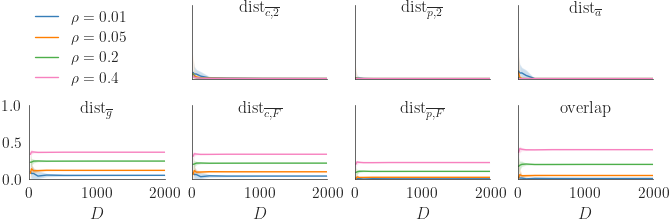

In [39]:
DATA = orth_by_N

fig, axes = synth_grid(height=FIG_HEIGHT)

plot_single(
    DATA,
    axes[0][1],
    "c2",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)
plot_single(
    DATA,
    axes[0][2],
    "p2",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)
plot_single(
    DATA,
    axes[0][3],
    "fs",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)

plot_single(
    DATA,
    axes[1][0],
    "arc",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][1],
    "cF",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][2],
    "pF",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][3],
    "ov",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)

# set titles
axes[0, 1].set_title(r"$\mathrm{dist}_{\overline{c,2}}$", y=1.0, pad=-6)
axes[0, 2].set_title(r"$\mathrm{dist}_{\overline{p,2}}$", y=1.0, pad=-6)
axes[0, 3].set_title(r"$\mathrm{dist}_{\overline{a}}$", y=1.0, pad=-6)
axes[1, 0].set_title(r"$\mathrm{dist}_{\overline{g}}$", y=1.0, pad=-6)
axes[1, 1].set_title(r"$\mathrm{dist}_{\overline{c,F}}$", y=1.0, pad=-6)
axes[1, 2].set_title(r"$\mathrm{dist}_{\overline{p,F}}$", y=1.0, pad=-6)
axes[1, 3].set_title(r"$\mathrm{overlap}$", y=1.0, pad=-6)

# grab legend from another axis and put it on ax00
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 0].legend(h, l, loc='upper left', frameon=False, handlelength=1.5, borderaxespad=0.0, labelspacing=0.4)

fig.savefig("plotting_code/plot_output/synth_D_OO.pdf")

# APPENDIX FIGURE: by-D, O-to-B

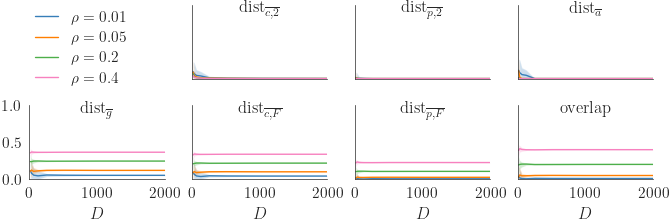

In [42]:
DATA = mixed_by_N

fig, axes = synth_grid(height=FIG_HEIGHT)

plot_single(
    DATA,
    axes[0][1],
    "c2",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)
plot_single(
    DATA,
    axes[0][2],
    "p2",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)
plot_single(
    DATA,
    axes[0][3],
    "fs",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)

plot_single(
    DATA,
    axes[1][0],
    "arc",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][1],
    "cF",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][2],
    "pF",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][3],
    "ov",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)

# set titles
axes[0, 1].set_title(r"$\mathrm{dist}_{\overline{c,2}}$", y=1.0, pad=-6)
axes[0, 2].set_title(r"$\mathrm{dist}_{\overline{p,2}}$", y=1.0, pad=-6)
axes[0, 3].set_title(r"$\mathrm{dist}_{\overline{a}}$", y=1.0, pad=-6)
axes[1, 0].set_title(r"$\mathrm{dist}_{\overline{g}}$", y=1.0, pad=-6)
axes[1, 1].set_title(r"$\mathrm{dist}_{\overline{c,F}}$", y=1.0, pad=-6)
axes[1, 2].set_title(r"$\mathrm{dist}_{\overline{p,F}}$", y=1.0, pad=-6)
axes[1, 3].set_title(r"$\mathrm{overlap}$", y=1.0, pad=-6)

# grab legend from another axis and put it on ax00
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 0].legend(h, l, loc='upper left', frameon=False, handlelength=1.5, borderaxespad=0.0, labelspacing=0.4)

fig.savefig("plotting_code/plot_output/synth_D_OB.pdf")

# APPENDIX FIGURE: by-D, B-to-B

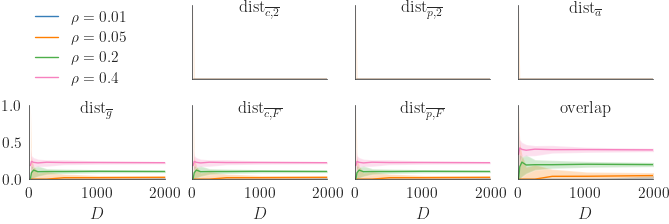

In [43]:
DATA = mask_by_N

fig, axes = synth_grid(height=FIG_HEIGHT)

plot_single(
    DATA,
    axes[0][1],
    "c2",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)
plot_single(
    DATA,
    axes[0][2],
    "p2",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)
plot_single(
    DATA,
    axes[0][3],
    "fs",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
)

plot_single(
    DATA,
    axes[1][0],
    "arc",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][1],
    "cF",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][2],
    "pF",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][3],
    "ov",
    by_k=False,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [yy for yy in y],
    filter_out_keys=FILTER_SPARSITIES,
    bottom_plot=True,
)

# set titles
axes[0, 1].set_title(r"$\mathrm{dist}_{\overline{c,2}}$", y=1.0, pad=-6)
axes[0, 2].set_title(r"$\mathrm{dist}_{\overline{p,2}}$", y=1.0, pad=-6)
axes[0, 3].set_title(r"$\mathrm{dist}_{\overline{a}}$", y=1.0, pad=-6)
axes[1, 0].set_title(r"$\mathrm{dist}_{\overline{g}}$", y=1.0, pad=-6)
axes[1, 1].set_title(r"$\mathrm{dist}_{\overline{c,F}}$", y=1.0, pad=-6)
axes[1, 2].set_title(r"$\mathrm{dist}_{\overline{p,F}}$", y=1.0, pad=-6)
axes[1, 3].set_title(r"$\mathrm{overlap}$", y=1.0, pad=-6)

# grab legend from another axis and put it on ax00
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 0].legend(h, l, loc='upper left', frameon=False, handlelength=1.5, borderaxespad=0.0, labelspacing=0.4)

fig.savefig("plotting_code/plot_output/synth_D_BB.pdf")

# APPENDIX FIGURE: by-r, O-to-O

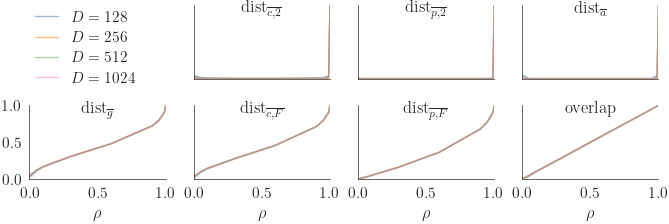

In [46]:
DATA = orth_by_sp

fig, axes = synth_grid(height=FIG_HEIGHT)

plot_single(
    DATA,
    axes[0][1],
    "c2",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)
plot_single(
    DATA,
    axes[0][2],
    "p2",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)
plot_single(
    DATA,
    axes[0][3],
    "fs",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)

plot_single(
    DATA,
    axes[1][0],
    "arc",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][1],
    "cF",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][2],
    "pF",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][3],
    "ov",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)

# set titles
axes[0, 1].set_title(r"$\mathrm{dist}_{\overline{c,2}}$", y=1.0, pad=-6)
axes[0, 2].set_title(r"$\mathrm{dist}_{\overline{p,2}}$", y=1.0, pad=-6)
axes[0, 3].set_title(r"$\mathrm{dist}_{\overline{a}}$", y=1.0, pad=-6)
axes[1, 0].set_title(r"$\mathrm{dist}_{\overline{g}}$", y=1.0, pad=-6)
axes[1, 1].set_title(r"$\mathrm{dist}_{\overline{c,F}}$", y=1.0, pad=-6)
axes[1, 2].set_title(r"$\mathrm{dist}_{\overline{p,F}}$", y=1.0, pad=-6)
axes[1, 3].set_title(r"$\mathrm{overlap}$", y=1.0, pad=-6)

# grab legend from another axis and put it on ax00
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 0].legend(h, l, loc='upper left', frameon=False, handlelength=1.5, borderaxespad=0.0, labelspacing=0.4)

fig.savefig("plotting_code/plot_output/synth_r_OO.pdf")

# APPENDIX FIGURE: by-r, O-to-B

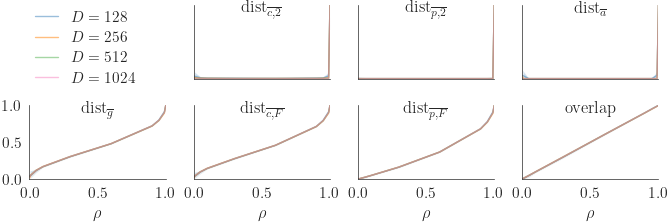

In [47]:
DATA = mixed_by_sp

fig, axes = synth_grid(height=FIG_HEIGHT)

plot_single(
    DATA,
    axes[0][1],
    "c2",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)
plot_single(
    DATA,
    axes[0][2],
    "p2",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)
plot_single(
    DATA,
    axes[0][3],
    "fs",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)

plot_single(
    DATA,
    axes[1][0],
    "arc",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][1],
    "cF",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][2],
    "pF",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][3],
    "ov",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)

# set titles
axes[0, 1].set_title(r"$\mathrm{dist}_{\overline{c,2}}$", y=1.0, pad=-6)
axes[0, 2].set_title(r"$\mathrm{dist}_{\overline{p,2}}$", y=1.0, pad=-6)
axes[0, 3].set_title(r"$\mathrm{dist}_{\overline{a}}$", y=1.0, pad=-6)
axes[1, 0].set_title(r"$\mathrm{dist}_{\overline{g}}$", y=1.0, pad=-6)
axes[1, 1].set_title(r"$\mathrm{dist}_{\overline{c,F}}$", y=1.0, pad=-6)
axes[1, 2].set_title(r"$\mathrm{dist}_{\overline{p,F}}$", y=1.0, pad=-6)
axes[1, 3].set_title(r"$\mathrm{overlap}$", y=1.0, pad=-6)

# grab legend from another axis and put it on ax00
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 0].legend(h, l, loc='upper left', frameon=False, handlelength=1.5, borderaxespad=0.0, labelspacing=0.4)

fig.savefig("plotting_code/plot_output/synth_r_OB.pdf")

# APPENDIX FIGURE: by-r, B-to-B

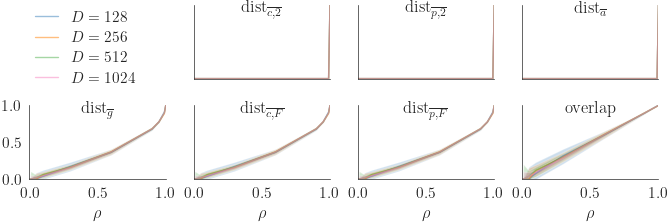

In [48]:
DATA = mask_by_sp

fig, axes = synth_grid(height=FIG_HEIGHT)

plot_single(
    DATA,
    axes[0][1],
    "c2",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)
plot_single(
    DATA,
    axes[0][2],
    "p2",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)
plot_single(
    DATA,
    axes[0][3],
    "fs",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
)

plot_single(
    DATA,
    axes[1][0],
    "arc",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][1],
    "cF",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][2],
    "pF",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [1 - yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)
plot_single(
    DATA,
    axes[1][3],
    "ov",
    by_k=True,
    linewidth=LINEWIDTH,
    fn_y=lambda y: [yy for yy in y],
    filter_out_keys=FILTER_DIMS,
    bottom_plot=True,
)

# set titles
axes[0, 1].set_title(r"$\mathrm{dist}_{\overline{c,2}}$", y=1.0, pad=-6)
axes[0, 2].set_title(r"$\mathrm{dist}_{\overline{p,2}}$", y=1.0, pad=-6)
axes[0, 3].set_title(r"$\mathrm{dist}_{\overline{a}}$", y=1.0, pad=-6)
axes[1, 0].set_title(r"$\mathrm{dist}_{\overline{g}}$", y=1.0, pad=-6)
axes[1, 1].set_title(r"$\mathrm{dist}_{\overline{c,F}}$", y=1.0, pad=-6)
axes[1, 2].set_title(r"$\mathrm{dist}_{\overline{p,F}}$", y=1.0, pad=-6)
axes[1, 3].set_title(r"$\mathrm{overlap}$", y=1.0, pad=-6)

# grab legend from another axis and put it on ax00
h, l = axes[0, 1].get_legend_handles_labels()
axes[0, 0].legend(h, l, loc='upper left', frameon=False, handlelength=1.5, borderaxespad=0.0, labelspacing=0.4)

fig.savefig("plotting_code/plot_output/synth_r_BB.pdf")